# **07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación**

**Integrantes del grupo:** \
Ane Moreno Oya \
Isabel María Suárez Sánchez \
Antonio Manuel Míguez Vega

## Carga del dataset

In [4]:
!pip install --upgrade --force-reinstall --no-deps kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.2
    Uninstalling kaggle-1.7.4.2:
      Successfully uninstalled kaggle-1.7.4.2


In [ ]:
from google.colab import files
files.upload()

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c plant-seedlings-classification

In [ ]:
!unzip plant-seedlings-classification.zip -d my_dataset

In [9]:
# Conectamos con nuestro Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Establezco una ruta absoluta a un directorio existente de mi Google Drive
BASE_FOLDER = "/content/drive/MyDrive/07MIAR_Proyecto_Programacion/"

Mounted at /content/drive


In [10]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

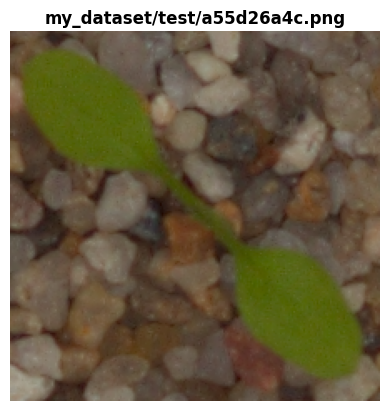

In [11]:
# Escogiendo y mostrando una imagen al azar del conjunto de test
image_dir = 'my_dataset/test/'
all_images = os.listdir(image_dir)

random_image = random.choice(all_images)

img_path = os.path.join(image_dir, random_image)
img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.title(img_path, fontweight='bold')
plt.axis('off')
plt.imshow(img)

In [12]:
print(f'Tamaño de imagen: {img.shape}')

Tamaño de imagen: (222, 222, 3)


In [13]:
import os

data_dir = 'my_dataset/train/'
classes = os.listdir(data_dir)

print(f"Número de clases: {len(classes)}\n")

for cls in sorted(classes):
    class_path = os.path.join(data_dir, cls)
    n_images = len(os.listdir(class_path))
    print(f"{cls}: {n_images} imágenes")

Número de clases: 12

Black-grass: 263 imágenes
Charlock: 390 imágenes
Cleavers: 287 imágenes
Common Chickweed: 611 imágenes
Common wheat: 221 imágenes
Fat Hen: 475 imágenes
Loose Silky-bent: 654 imágenes
Maize: 221 imágenes
Scentless Mayweed: 516 imágenes
Shepherds Purse: 231 imágenes
Small-flowered Cranesbill: 496 imágenes
Sugar beet: 385 imágenes


In [14]:
 from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
 # 2. Normalización por canal
img_channel_norm = img.astype('float32')
for i in range(3):  # Para cada canal (R, G, B)
  channel = img_channel_norm[:, :, i]
  channel = (channel -channel.mean()) / channel.std()
  img_channel_norm[:, :, i] = channel

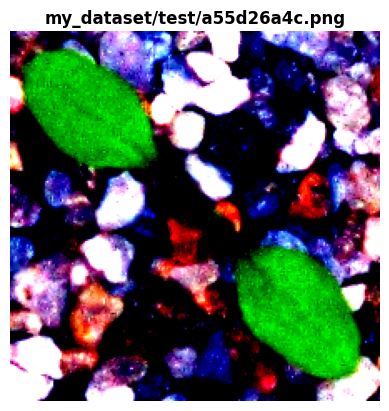

In [16]:
plt.title(img_path, fontweight='bold')
plt.axis('off')
plt.imshow(img_channel_norm)

In [17]:
datagen = ImageDataGenerator(
 rotation_range=20,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.2,
 zoom_range=0.2,
 horizontal_flip=True,
 fill_mode='nearest'
 )

In [18]:
# Preparar imagen para el generador
img_para_aumentar = np.expand_dims(img_channel_norm, 0)

In [19]:
aumentadas = []
titulos_aumentadas = []
for i, batch in enumerate(datagen.flow(img_para_aumentar, batch_size=1)):
  aumentadas.append(batch[0])
  titulos_aumentadas.append(f'Aumentada {i+1}')
  if i >= 4:
    break

In [20]:
def mostrar_imagenes(imagenes, titulos):
  fig, axs = plt.subplots(1, len(imagenes), figsize=(15, 3))
  for i, (img, titulo) in enumerate(zip(imagenes, titulos)):
    axs[i].imshow(img)
    axs[i].set_title(titulo)
    axs[i].axis('off')
  plt.tight_layout()
  plt.show()

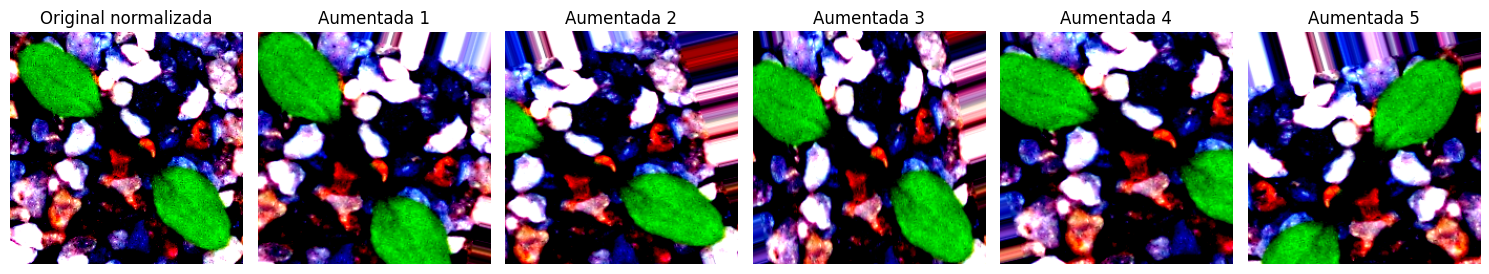

In [21]:
mostrar_imagenes([img_channel_norm] + aumentadas, ['Original normalizada'] + titulos_aumentadas)

Ahora, generalizamos el preprocesamiento para las imágenes del set de entrenamiento.

In [22]:
def normalize_per_channel(img):
    img = img.astype('float32')
    for i in range(3):  # Para cada canal: R, G, B
        channel = img[:, :, i]
        mean = channel.mean()
        std = channel.std() if channel.std() > 0 else 1.0
        img[:, :, i] = (channel - mean) / std
    return img

In [23]:
seed_value = 42
np.random.seed(seed_value)  # Para reproducibilidad

datagen = ImageDataGenerator(
 preprocessing_function=normalize_per_channel,
 rotation_range=20,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.2,
 zoom_range=0.2,
 horizontal_flip=True,
 fill_mode='nearest',
 validation_split=0.2 # 20% para validación
 )

In [24]:
train_generator = datagen.flow_from_directory(
    'my_dataset/train',
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='training' # Especifica que es el conjunto de entrenamiento
)

val_generator = datagen.flow_from_directory(
    'my_dataset/train',
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='validation' # Especifica que es el conjunto de validación
)

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [25]:
# Inicializamos un diccionario para contar las muestras por clase
class_counts = {class_name: 0 for class_name in val_generator.class_indices.keys()}

# Obtenemos el número total de muestras
total_samples = val_generator.samples
steps = (total_samples + val_generator.batch_size - 1) // val_generator.batch_size

# Recorremos el número necesario de lotes
for i in range(steps):
    images, labels = next(val_generator)

    # Obtenemos los índices de las clases en el lote
    batch_labels = np.argmax(labels, axis=1)

    # Contamos las ocurrencias de cada clase en este lote
    unique, counts = np.unique(batch_labels, return_counts=True)

    # Actualizamos el total de conteos por clase
    for class_idx, count in zip(unique, counts):
        class_name = list(val_generator.class_indices.keys())[class_idx]
        class_counts[class_name] += count

# Imprimimos el conteo por clase
for class_name, count in class_counts.items():
    print(f"Clase: {class_name}, Número de observaciones: {count}")

Clase: Black-grass, Número de observaciones: 52
Clase: Charlock, Número de observaciones: 78
Clase: Cleavers, Número de observaciones: 57
Clase: Common Chickweed, Número de observaciones: 122
Clase: Common wheat, Número de observaciones: 44
Clase: Fat Hen, Número de observaciones: 95
Clase: Loose Silky-bent, Número de observaciones: 130
Clase: Maize, Número de observaciones: 44
Clase: Scentless Mayweed, Número de observaciones: 103
Clase: Shepherds Purse, Número de observaciones: 46
Clase: Small-flowered Cranesbill, Número de observaciones: 99
Clase: Sugar beet, Número de observaciones: 77


In [ ]:
#test_datagen = ImageDataGenerator(
#    preprocessing_function=normalize_per_channel
#)

#test_generator = test_datagen.flow_from_directory(
#    'my_dataset/test',
#    target_size=(32, 32),
#    batch_size=32,
#    class_mode='categorical',
#    shuffle=False  # muy importante para evaluar correctamente
#)

## Estrategia 1: Entrenamiento desde Cero (From Scratch)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

In [ ]:
def crear_red():
    # Capa de entrada: imágenes de tamaño 32x32 con 3 canales (RGB)
    inputs = Input(shape=(32, 32, 3))

    # Primer bloque convolucional
    # Se aplica una convolución con 32 filtros de tamaño 3x3 y activación ReLU
    # Se incluye regularización L2 para penalizar grandes valores de pesos
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
    # Normalización por lotes para estabilizar y acelerar el aprendizaje
    x = BatchNormalization()(x)
    # Segunda capa convolucional del bloque
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # Reducción de dimensionalidad mediante max pooling
    x = MaxPooling2D((2, 2))(x)
    # Regularización adicional mediante dropout
    x = Dropout(0.25)(x)

    # Segundo bloque convolucional con 64 filtros
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Aplanamiento del volumen 3D a un vector 1D para su procesamiento por capas densas
    x = Flatten()(x)

    # Capa densa totalmente conectada con 128 neuronas y activación ReLU
    # Incluye regularización L2
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # Dropout más agresivo para prevenir sobreajuste en esta etapa de mayor capacidad
    x = Dropout(0.5)(x)

    # Capa de salida con activación softmax para clasificación multiclase (12 clases)
    outputs = Dense(12, activation='softmax')(x)

    # Definición del modelo completo
    model = Model(inputs, outputs)

    # Compilación del modelo con el optimizador Adam y función de pérdida adecuada para clasificación multiclase
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
model = crear_red()
history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 105s 831ms/step - accuracy: 0.1590 - loss: 3.5354 - val_accuracy: 0.2809 - val_loss: 2.6990
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 86s 722ms/step - accuracy: 0.3372 - loss: 2.5235 - val_accuracy: 0.3474 - val_loss: 2.4797
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 142s 725ms/step - accuracy: 0.3990 - loss: 2.2365 - val_accuracy: 0.4625 - val_loss: 2.0124
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 84s 704ms/step - accuracy: 0.4567 - loss: 2.0026 - val_accuracy: 0.5438 - val_loss: 1.7872
Epoch 5/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 85s 711ms/step - accuracy: 0.5120 - loss: 1.8708 - val_accuracy: 0.5755 - val_loss: 1.6902
Epoch 6/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 86s 727ms/step - accuracy: 0.5454 - loss: 1.7706 - val_accuracy: 0.5882 - val_loss: 1.6215
Epoch 7/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 88s 737ms/step - accuracy: 0.5643 - loss: 1.6935 - val_accuracy: 0.6283 - val_loss: 1.5046
Epoch 8/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 90s 757ms/step - accuracy: 0.6009 - loss:

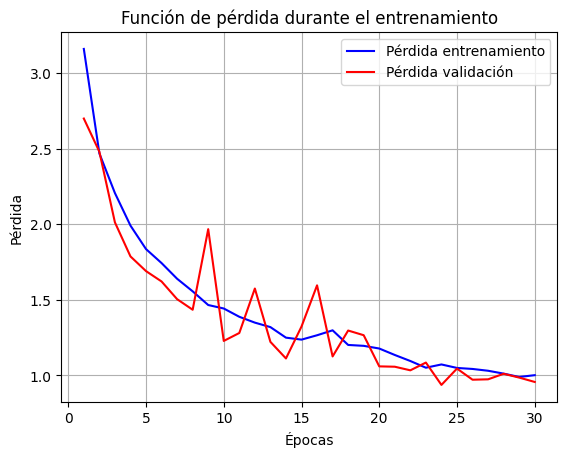

In [ ]:
# Obtener valores de pérdida
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Crear el gráfico
plt.plot(epochs, loss, 'b', label='Pérdida entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida validación')
plt.title('Función de pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()

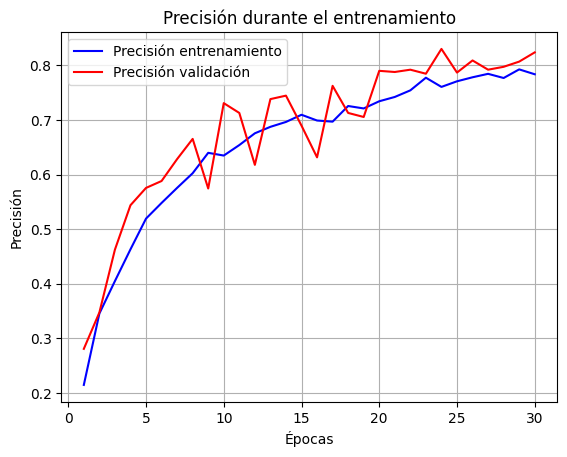

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Precisión entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Precisión validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Guardar el modelo
model.save("/content/drive/My Drive/modelo_scratch.keras")

In [ ]:
# Cargar el modelo guardado
from tensorflow.keras.models import load_model
nuevo_modelo = load_model("/content/drive/My Drive/modelo_scratch.keras")

## Estrategia 2: Red pre-entrenada

In [26]:
# --- Imports necesarios ---
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2 # Usaremos MobileNetV2
from tensorflow.keras.models import Model # Usaremos la API funcional para más flexibilidad
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [34]:
# --- Parámetros ---
data_dir = '/content/my_dataset/train/'

img_size = (96, 96) # Aumentado respecto a (32,32) para mejor rendimiento con MobileNetV2
batch_size = 32
num_classes = 12
initial_epochs = 15 # Épocas para entrenar solo el clasificador 'top'
fine_tune_epochs = 15 # Épocas para el fine-tuning
total_epochs = initial_epochs + fine_tune_epochs
learning_rate_base = 0.001 # Tasa de aprendizaje inicial
learning_rate_fine_tune = learning_rate_base / 10 # Tasa de aprendizaje reducida para fine-tuning

In [35]:
# --- Preparación de Generadores de Datos (similar a Estrategia 1) ---
# Data Augmentation y Preprocesamiento para MobileNetV2
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2, # 20% para validación
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input # Preprocesado MobileNetV2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False # No es necesario barajar la validación
)

print(f"Clases encontradas: {train_generator.num_classes}")
print(f"Índices de clases: {train_generator.class_indices}")

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
Clases encontradas: 12
Índices de clases: {'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}


In [39]:
# --- 2. Carga del Modelo Base (MobileNetV2) y Congelación ---
# Definir input_tensor explícitamente
input_tensor = Input(shape=(img_size[0], img_size[1], 3))

base_model = MobileNetV2(
    input_tensor=input_tensor,
    input_shape=(img_size[0], img_size[1], 3),
    weights='imagenet',
    include_top=False # No incluir el clasificador original de ImageNet
)

# Congelar todas las capas del modelo base inicialmente
base_model.trainable = False

print(f"Número de capas en el modelo base: {len(base_model.layers)}")

# --- 3. Añadir Clasificador Personalizado (Top) ---
x = base_model.output
x = GlobalAveragePooling2D()(x) # Capa de Pooling Global Promedio
x = Dropout(0.5)(x) # Dropout para regularización
predictions = Dense(num_classes, activation='softmax')(x) # Capa de salida

# Construir el modelo final
model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

# --- 4. Compilar el Modelo (Fase 1: Entrenar solo el Top) ---
model_mobilenet.compile(
    optimizer=Adam(learning_rate=learning_rate_base),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nResumen del modelo antes del fine-tuning (base congelada):")
model_mobilenet.summary()

Número de capas en el modelo base: 154

Resumen del modelo antes del fine-tuning (base congelada):


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [40]:
# --- 5. Entrenar el Modelo (Fase 1: Solo el Top) ---
print(f"\nEntrenando solo el clasificador superior durante {initial_epochs} épocas...")

history = model_mobilenet.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=validation_generator,
    steps_per_epoch=(train_generator.samples + batch_size - 1) // batch_size,
    validation_steps=(validation_generator.samples + batch_size - 1) // batch_size
)


Entrenando solo el clasificador superior durante 15 épocas...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_785']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


118/118 ━━━━━━━━━━━━━━━━━━━━ 102s 814ms/step - accuracy: 0.1850 - loss: 2.9805 - val_accuracy: 0.4935 - val_loss: 1.4953
Epoch 2/15
  1/118 ━━━━━━━━━━━━━━━━━━━━ 30s 258ms/step - accuracy: 0.3750 - loss: 2.0465

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.3750 - loss: 2.0465 - val_accuracy: 0.5075 - val_loss: 1.4856
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 141s 974ms/step - accuracy: 0.3945 - loss: 1.8851 - val_accuracy: 0.5830 - val_loss: 1.2462
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.4062 - loss: 1.8172 - val_accuracy: 0.5884 - val_loss: 1.2357
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.4958 - loss: 1.5391 - val_accuracy: 0.6401 - val_loss: 1.1363
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.4688 - loss: 1.3297 - val_accuracy: 0.6228 - val_loss: 1.1322
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.5453 - loss: 1.3576 - val_accuracy: 0.6358 - val_loss: 1.0599
Epoch 8/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - accuracy: 0.4375 - loss: 1.5856 - val_accuracy: 0.6390 - val_loss: 1.0518
Epoch 9/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 92s 775ms/step - accuracy: 0.5599 - loss: 1.3045 - val_ac

In [41]:
# Guardar métricas de la primera fase
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [42]:
# --- 6. Preparación para Fine-Tuning ---
print("\nPreparando para fine-tuning...")

# Descongelar el modelo base
base_model.trainable = True

# Decidir cuántas capas descongelar desde el final.
# MobileNetV2 tiene bloques. Una estrategia común es descongelar los últimos bloques.
fine_tune_at = 100 # Descongelar desde la capa 100 en adelante (ajusta según sea necesario)

# Congelar todas las capas ANTES de 'fine_tune_at'
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
# Las capas desde 'fine_tune_at' en adelante estarán entrenables (ya que base_model.trainable = True)

print(f"Número total de capas: {len(model_mobilenet.layers)}")
print(f"Número de capas entrenables después de descongelar para fine-tuning: {len(model_mobilenet.trainable_variables)}")

# --- 7. Re-compilar el Modelo para Fine-Tuning ---
# Es crucial usar una tasa de aprendizaje mucho más baja para no destruir los pesos preentrenados
model_mobilenet.compile(
    optimizer=Adam(learning_rate=learning_rate_fine_tune), # Tasa de aprendizaje MUY BAJA
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nResumen del modelo para fine-tuning:")
model_mobilenet.summary()


Preparando para fine-tuning...
Número total de capas: 157
Número de capas entrenables después de descongelar para fine-tuning: 56

Resumen del modelo para fine-tuning:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 1,876,812 (7.16 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [43]:
# --- 8. Continuar Entrenamiento (Fase 2: Fine-Tuning) ---
print(f"\nRealizando fine-tuning durante {fine_tune_epochs} épocas adicionales...")

history_fine = model_mobilenet.fit(
    train_generator,
    epochs=total_epochs, # Entrenar hasta el total de épocas
    initial_epoch=history.epoch[-1] + 1, # Empezar desde la época siguiente a la última de la fase 1
    validation_data=validation_generator,
    steps_per_epoch=(train_generator.samples + batch_size - 1) // batch_size,
    validation_steps=(validation_generator.samples + batch_size - 1) // batch_size
)


Realizando fine-tuning durante 15 épocas adicionales...
Epoch 16/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.4042 - loss: 2.2000 - val_accuracy: 0.4731 - val_loss: 2.0802
Epoch 17/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 0.6562 - loss: 0.9859 - val_accuracy: 0.4795 - val_loss: 2.0431
Epoch 18/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 116s 950ms/step - accuracy: 0.6312 - loss: 1.1098 - val_accuracy: 0.5183 - val_loss: 2.0079
Epoch 19/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.6875 - loss: 1.1171 - val_accuracy: 0.5151 - val_loss: 1.9925
Epoch 20/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 115s 973ms/step - accuracy: 0.6799 - loss: 0.9332 - val_accuracy: 0.5797 - val_loss: 1.6457
Epoch 21/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 0.7812 - loss: 0.5372 - val_accuracy: 0.5927 - val_loss: 1.6042
Epoch 22/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 113s 953ms/step - accuracy: 0.7413 - loss: 0.7360 - val_accuracy: 0.5862 - val_loss: 1.6180
Epoch 23/30
118/11


Graficando historial completo de entrenamiento...


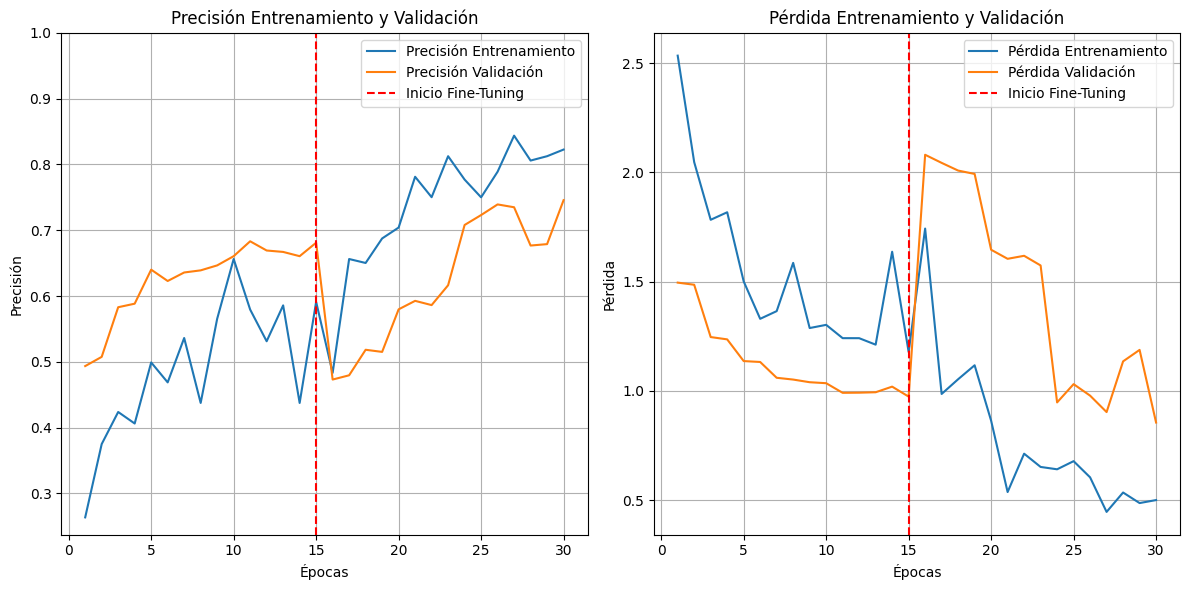

In [44]:
# --- 9. Combinar Historias y Visualizar ---
# Añadir las métricas de la fase de fine-tuning a las anteriores
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

# Graficar resultados
print("\nGraficando historial completo de entrenamiento...")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs + 1), acc, label='Precisión Entrenamiento')
plt.plot(range(1, total_epochs + 1), val_acc, label='Precisión Validación')
plt.axvline(initial_epochs, linestyle='--', color='r', label='Inicio Fine-Tuning') # Línea vertical
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim([min(min(acc), min(val_acc)) * 0.9, 1.0]) # Ajustar límites Y si es necesario
plt.legend()
plt.title('Precisión Entrenamiento y Validación')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs + 1), loss, label='Pérdida Entrenamiento')
plt.plot(range(1, total_epochs + 1), val_loss, label='Pérdida Validación')
plt.axvline(initial_epochs, linestyle='--', color='r', label='Inicio Fine-Tuning') # Línea vertical
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida Entrenamiento y Validación')
plt.grid(True)

plt.tight_layout()
plt.show()

In [45]:
# --- 10. Evaluación Final ---
print("\nEvaluando el modelo final fine-tuned en el conjunto de validación...")
final_loss, final_accuracy = model_mobilenet.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f'Pérdida Final (Validación): {final_loss:.4f}')
print(f'Precisión Final (Validación): {final_accuracy:.4f}')


Evaluando el modelo final fine-tuned en el conjunto de validación...
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 594ms/step - accuracy: 0.6625 - loss: 1.1420
Pérdida Final (Validación): 0.8965
Precisión Final (Validación): 0.7575


In [46]:
# --- 11. Guardar el Modelo Fine-Tuned ---
model_mobilenet.save("/content/drive/My Drive/modelo_mobilenet_finetuned.keras")
print("Modelo MobileNetV2 fine-tuned guardado.")

Modelo MobileNetV2 fine-tuned guardado.
